# A toy example

In [3]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np 
import matplotlib.pyplot as plt


## Data

[[247.0247 ]
 [248.24417]
 [253.10529]
 ...
 [245.52885]
 [246.99973]
 [251.74072]]


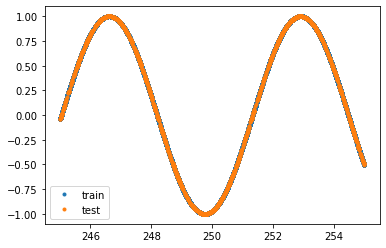

In [4]:
data = np.random.uniform(size=(64 * 1025, 1), low=-5., high=5.) + 250.

data = data.astype(np.float32)

x_train = data[:64*1000, :]
x_test = data[64*1000:, :]

y_train = np.sin(x_train) #+ np.random.normal(size=x_train.shape) / 10.
y_test = np.sin(x_test)

mean_train = np.mean(x_train)
var_train = np.var(x_train)

plt.plot(x_train, y_train, '.')
plt.plot(x_test, y_test, '.')
plt.legend(["train", "test"])

#x_train = (x_train - mean_train) / var_train
#x_test = (x_test - mean_train) / var_train

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

print(x_train)


## Model

In [5]:
class MyDenseLayer(keras.layers.Layer):
  def __init__(self, units=32):
    super(MyDenseLayer, self).__init__()
    self.units=units

  def build(self, input_shape):
    w_init = tf.initializers.glorot_uniform()
    self.w = tf.Variable(
        initial_value=w_init(shape=(input_shape[-1], self.units), dtype="float32"), trainable=True
    )
    b_init = tf.zeros_initializer()
    self.b = tf.Variable(
        initial_value=b_init(shape=(self.units, ), dtype="float32"), trainable=True
    )
    
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

In [6]:

inputs = keras.Input(1, name="input_layer")
hidden_layer_1 = MyDenseLayer(32)
hidden_layer_2 = MyDenseLayer(32)
output_layer = MyDenseLayer(1)

x = (inputs - mean_train) / tf.sqrt(var_train)
x = hidden_layer_1(x)
x = tf.tanh(x)
x = hidden_layer_2(x)
x = tf.tanh(x)
outputs = output_layer(x)

model = keras.Model(inputs=inputs, outputs=outputs)

def my_loss(y_true, y_pred):
  return tf.math.reduce_mean((y_true - y_pred) ** 2)


optimizer=keras.optimizers.Adam(learning_rate=0.001)
train_metric = keras.metrics.RootMeanSquaredError()
test_metric = keras.metrics.RootMeanSquaredError()

In [7]:
xx = model(np.array([[1.]]))
print(xx)

print(hidden_layer_2.weights)

tf.Tensor([[1.0156107]], shape=(1, 1), dtype=float32)
[<tf.Variable 'my_dense_layer_1/Variable:0' shape=(32, 32) dtype=float32, numpy=
array([[ 0.24518076,  0.20370749, -0.20586357, ..., -0.2538892 ,
         0.11612669,  0.12021691],
       [-0.16084197,  0.28834572,  0.09625232, ..., -0.23675314,
        -0.18959635, -0.10689338],
       [-0.25175443, -0.28603095,  0.1550669 , ..., -0.25062263,
         0.02138358,  0.13796246],
       ...,
       [ 0.10219052, -0.18927675, -0.03486064, ..., -0.01124376,
        -0.14437701,  0.2778516 ],
       [ 0.09100991,  0.211225  , -0.0161745 , ..., -0.11202984,
        -0.04180548, -0.13967599],
       [-0.24278939, -0.1958124 ,  0.1435718 , ..., -0.24879558,
        -0.02091122,  0.28905025]], dtype=float32)>, <tf.Variable 'my_dense_layer_1/Variable:0' shape=(32,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=flo

## Training

In [ ]:
epochs = 10

for epoch in range(epochs):
  print("epoch: %d" % (epoch, ))

  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      y_values = model(x_batch_train, training=True)
      loss_value = my_loss(y_batch_train, y_values)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_metric.update_state(y_batch_train, y_values)

    if step % 200 == 0:
      print("loss for one batch at step %d: %f" % (step, loss_value))

    
  train_acc = train_metric.result()
  print("train metric: %f" % (train_acc, ))

  train_metric.reset_states()

  for x_batch_test, y_batch_test in test_dataset:
    y_values = model(x_batch_test, training=False)
    test_metric.update_state(y_batch_test, y_values)

  test_acc = test_metric.result()
  test_metric.reset_states()
  print("test metric: %f" % (test_acc, ))


epoch: 0
loss for one batch at step 0: 0.504358
loss for one batch at step 200: 0.343796
loss for one batch at step 400: 0.063375
loss for one batch at step 600: 0.091099
loss for one batch at step 800: 0.071429
train metric: 0.395109
test metric: 0.232097
epoch: 1
loss for one batch at step 0: 0.041085
loss for one batch at step 200: 0.054442
loss for one batch at step 400: 0.024750
loss for one batch at step 600: 0.013688
loss for one batch at step 800: 0.007810


In [ ]:
x = np.linspace(-5., 5., 100) + 250.

plt.plot(x, np.sin(x))

print(x.shape)

x = np.reshape(x, (-1, 1))

print(x.shape)

plt.plot(x, model(x))

plt.legend(["sin", "model"])

In [ ]:
model.summary()

keras.utils.plot_model(model, "model.png", show_shapes=True)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir log